# Text and Multimedia Mining Project 2020-2021
This notebook contains the code of the project "Dynamic topic modeling on ASD-related articles" for the course Text and Multimedia Mining constructed by Luna-Elise Schernthaner (s4703928).

The datasets are obtained with the help of the tutorial found at http://biopython.org/DIST/docs/tutorial/Tutorial.html (Section 9.16)

## Steps

1.   Get all English non-review abstracts from PubMed containing terms related to ASD published between January 1 2009 and December 31 2018, including their metadata (authors, date, meSH terms, etc), as well as all English review abstracts related to ASD published between January 1 2010 and December 31 2019
2.   Visualise the data

The rest of this analysis is performed in python code separate from this notebook

3.   Perform preprocessing on the articles (tokenization, POS tagging, etc)
4.   Perform dynamic topic modeling (including tuning hyperparameters)
5.   Visualise the results (with e.g. wordclouds)
6.   Verify results manually by comparing topics in review articles with found topics


### Step 1a: Retrieve main dataset
#### ONLY RUN ON WEEKENDS OR BETWEEN 9:00 PM AND 5:00 AM EASTERN TIME DURING WEEKDAYS

In [ ]:
pip install biopython

In [ ]:
from Bio import Entrez
import xml.etree.ElementTree as ET
import os

!mkdir mainQueryFiles

Entrez.email = 'L.schernthaner@student.ru.nl'
Entrez.tool = 'ASD_Topic_Modeling_2009_2019'

mainQuery = 'autism NOT review AND 2009:2018[dp] AND English[Language]' #24,487 results

In [ ]:
# Retrieve main dataset
# ONLY RUN ON WEEKENDS OR BETWEEN 9:00 PM AND 5:00 AM EASTERN TIME DURING WEEKDAYS

search_handle = Entrez.esearch(db="pubmed",term=mainQuery, usehistory="y")
search_results = Entrez.read(search_handle)
search_handle.close()

webenv = search_results["WebEnv"]
query_key = search_results["QueryKey"]
count = int(search_results["Count"])

fileNo = 1
batch_size = 3
for start in range(0, count, batch_size):
    with open(f"/content/mainQueryFiles/mainQuery{fileNo}.xml", "w") as out_handle:
      end = min(count, start + batch_size)
      print("Going to download record %i to %i" % (start + 1, end))
      fetch_handle = Entrez.efetch(
          db="pubmed",
          retstart=start,
          retmax=batch_size,
          webenv=webenv,
          query_key=query_key,
          retmode="xml"
      )
      data = fetch_handle.read().decode("UTF-8")
      fetch_handle.close()
      out_handle.write(data)
    fileNo = fileNo + 1

In [ ]:
# Merge retrieved batches of main query into 1 XML file

# Initialise merging XML structure
firstFile ="/content/mainQueryFiles/mainQuery1.xml"
target="/content/mainQueryFiles/combinedMainQuery.xml"
tree = ET.parse(firstFile)
PMArticleSet = tree.getroot()

# Combine all XML files into one
directory = "/content/mainQueryFiles/"
for batch in os.scandir(directory):
  if batch.name in [firstFile, target]:
    continue
  print(batch.name)
  newTree = ET.parse(batch)
  newPMArticleSet = newTree.getroot()
  for newPMArticle in newPMArticleSet:
    PMArticleSet.append(newPMArticle)
tree.write(target)

### Step 2a: Visualise main dataset

In [ ]:
import xml.etree.ElementTree as ET
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [ ]:
# From each article, get the abstract and publication date information and put into table

mainData = pd.DataFrame(None , columns = ['Abstract', 'Year', 'Month', 'Day'])
tree = ET.parse("/content/combinedMainQuery.xml")
PMArticleSet = tree.getroot()
for PMArticle in PMArticleSet:
  try:
    abstractText = " ".join([part.text for part in list(PMArticle.iter('AbstractText'))])
  except:
    abstractText = None
  pubDate = list(PMArticle.iter('PubDate'))[0]
  try:
    pubYear = list(pubDate.iter('Year'))[0].text
  except:
    pubYear = None
  try:
    pubMonth = list(pubDate.iter('Month'))[0].text
  except:
    pubMonth = None
  try:
    pubDay = list(pubDate.iter('Day'))[0].text
  except:
    pubDay = None
  mainData = mainData.append({'Abstract': abstractText, 'Year': pubYear, 'Month': pubMonth, 'Day': pubDay}, ignore_index=True)
mainData = mainData.sort_values(by=['Year'])

In [ ]:
# Visualise the dataset by year

plt.figure(figsize=(8,4))
sns.countplot(x='Year', data=mainData);

In [ ]:
# Filter out unusable data
# There are 1096 articles without a year or abstract or both

print(len(mainData) - len(mainData.loc[(mainData['Abstract'].isnull()) | (mainData['Year'].isnull()) ]))
print(len(mainData.loc[ (mainData['Abstract'].notnull()) & (mainData['Year'].notnull()) ]))
mainData = mainData.loc[ (mainData['Abstract'].notnull()) & (mainData['Year'].notnull()) ]

mainData['Year'].astype(int)
mainData['Year'] = pd.to_numeric(mainData['Year'])
mainData['Day'] = pd.to_numeric(mainData['Day'])

print(len(mainData) - len(mainData.loc[ (mainData['Year'] < 2009) | (mainData['Year'] > 2018) ]))
print(len(mainData.loc[ (mainData['Year'] >= 2009) & (mainData['Year'] <= 2018) ]))
mainData = mainData.loc[ (mainData['Year'] >= 2009) & (mainData['Year'] <= 2018) ]

In [ ]:
mainData['Year'] = mainData['Year'].astype(int)

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(x='Year', data=mainData);

In [ ]:
# Get number of articles published each year

artCounts = mainData[['Year','Abstract']].groupby(['Year']).count()
noArtYear = artCounts['Abstract'].tolist()
noArtYear

In [ ]:
# Save main data for further analysis

mainData.to_pickle('/content/mainData_unprocessed.pkl')

### Step 1b: Retrieve validation dataset
#### ONLY RUN ON WEEKENDS OR BETWEEN 9:00 PM AND 5:00 AM EASTERN TIME DURING WEEKDAYS

In [1]:
pip install biopython

     |████████████████████████████████| 2.3MB 7.6MB/s 


In [2]:
from Bio import Entrez
import xml.etree.ElementTree as ET
import os

!mkdir validationQueryFiles

Entrez.email = 'L.schernthaner@student.ru.nl'
Entrez.tool = 'ASD_Topic_Modeling_2009_2019'

validationQuery = 'autism AND review AND 2010:2019[dp] AND English[Language]' # 6,580 results

In [ ]:
# Retrieve validation dataset
# ONLY RUN ON WEEKENDS OR BETWEEN 9:00 PM AND 5:00 AM EASTERN TIME DURING WEEKDAYS

search_handle = Entrez.esearch(db="pubmed",term=validationQuery, usehistory="y")
search_results = Entrez.read(search_handle)
search_handle.close()

webenv = search_results["WebEnv"]
query_key = search_results["QueryKey"]
count = int(search_results["Count"])

fileNo = 1
batch_size = 3
for start in range(0, count, batch_size):
    with open(f"/content/validationQueryFiles/validationQuery{fileNo}.xml", "w") as out_handle:
      end = min(count, start + batch_size)
      print("Going to download record %i to %i" % (start + 1, end))
      fetch_handle = Entrez.efetch(
          db="pubmed",
          retstart=start,
          retmax=batch_size,
          webenv=webenv,
          query_key=query_key,
          retmode="xml"
      )
      data = fetch_handle.read().decode("UTF-8")
      fetch_handle.close()
      out_handle.write(data)
    fileNo = fileNo + 1

In [ ]:
# Merge retrieved batches of validation query into 1 XML file

# Initialise merging XML structure
firstFile ="/content/validationQueryFiles/validationQuery1.xml"
target="/content/validationQueryFiles/combinedValidationQuery.xml"
tree = ET.parse(firstFile)
PMArticleSet = tree.getroot()

# Combine all XML files into one
directory = "/content/validationQueryFiles/"
for batch in os.scandir(directory):
  if batch.name in [firstFile, target]:
    continue
  print(batch.name)
  newTree = ET.parse(batch)
  newPMArticleSet = newTree.getroot()
  for newPMArticle in newPMArticleSet:
    PMArticleSet.append(newPMArticle)
tree.write(target)

### Step 2b: Visualise validation dataset

In [6]:
import xml.etree.ElementTree as ET
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [14]:
# From each article, get the abstract and publication date information and put into table

validationData = pd.DataFrame(None , columns = ['Abstract', 'Year', 'Month', 'Day'])
tree = ET.parse("/content/validationQueryFiles/combinedValidationQuery.xml")
PMArticleSet = tree.getroot()
for PMArticle in PMArticleSet:
  try:
    abstractText = " ".join([part.text for part in list(PMArticle.iter('AbstractText'))])
  except:
    abstractText = None
  pubDate = list(PMArticle.iter('PubDate'))[0]
  try:
    pubYear = list(pubDate.iter('Year'))[0].text
  except:
    pubYear = None
  try:
    pubMonth = list(pubDate.iter('Month'))[0].text
  except:
    pubMonth = None
  try:
    pubDay = list(pubDate.iter('Day'))[0].text
  except:
    pubDay = None
  validationData = validationData.append({'Abstract': abstractText, 'Year': pubYear, 'Month': pubMonth, 'Day': pubDay}, ignore_index=True)
validationData = validationData.sort_values(by=['Year'])

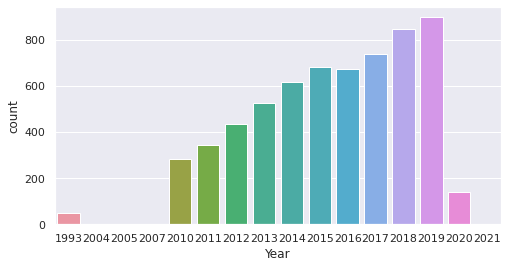

In [15]:
# Visualise the validation data by year

plt.figure(figsize=(8,4))
sns.countplot(x='Year', data=validationData);

In [16]:
# Filter out unusable data
# There are 6117 articles without a year or abstract or both

print(len(validationData) - len(validationData.loc[(validationData['Abstract'].isnull()) | (validationData['Year'].isnull()) ]))
print(len(validationData.loc[ (validationData['Abstract'].notnull()) & (validationData['Year'].notnull()) ]))
validationData = validationData.loc[ (validationData['Abstract'].notnull()) & (validationData['Year'].notnull()) ]

validationData['Year'].astype(int)
validationData['Year'] = pd.to_numeric(validationData['Year'])
validationData['Day'] = pd.to_numeric(validationData['Day'])

print(len(validationData) - len(validationData.loc[ (validationData['Year'] < 2010) | (validationData['Year'] > 2019) ]))
print(len(validationData.loc[ (validationData['Year'] >= 2010) & (validationData['Year'] <= 2019) ]))
validationData = validationData.loc[ (validationData['Year'] >= 2010) & (validationData['Year'] <= 2019) ]

6117
6117
5976
5976


In [17]:
validationData['Year'] = validationData['Year'].astype(int)

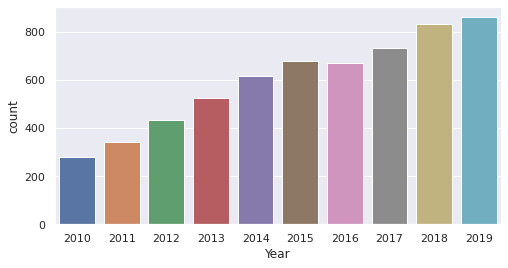

In [18]:
plt.figure(figsize=(8,4))
sns.countplot(x='Year', data=validationData);

In [19]:
# Get number of articles published each year

artCounts = validationData[['Year','Abstract']].groupby(['Year']).count()
noArtYear = artCounts['Abstract'].tolist()
noArtYear

[281, 344, 432, 524, 617, 680, 669, 734, 834, 861]

In [20]:
# Save validation data for further analysis

validationData.to_pickle('/content/validationData_unprocessed.pkl')